<img src="https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Segmentation.png" width="400"/>

# EconMLケーススタディ - 顧客セグメンテーション -- インセンティブに対する個別の反応を推定する

## 顧客セグメンテーション -- インセンティブに対する個別の反応を推定する

現在、ビジネスの意思決定者は、特定の製品を割引で宣伝する、ウェブサイトに新機能を追加する、営業チームからの投資を増やすなど、戦略のシフトに関するWhat-ifの質問（もし〜したらどうなるか？）に答えるために、介入の因果関係を推定することに頼っています。しかし、すべてのユーザーに関して特定の介入に対して行動を起こすかどうかを知るよりも、2つの選択肢に対する異なるユーザーの異なる反応を理解することに関心が高まっています。介入に対して最も強い反応を示すユーザーの特徴を特定することは、将来のユーザーを異なるグループにセグメントするためのルール作りに役立つ可能性があります。これは、最小のリソースを使用し、最大の利益を得るために政策を最適化するのに役立つ可能性があります。

このケーススタディでは、パーソナライズされた価格設定の例を用いて、EconMLライブラリがこの問題にどのように適合し、堅牢で信頼性の高い因果関係の解決策を提供できるかを説明します。

### 概要

1. 背景
2. データ
3. EconMLで因果関係を取得する
4. EconMLで処置効果を理解する
5. EconMLで方針決定を行う
6. 結論


## 背景

<img src="https://cdn.pixabay.com/photo/2018/08/16/11/59/radio-3610287_960_720.png" width="400" />

世界のオンラインメディア市場は、年々急速に成長しています。メディア企業は、より多くのユーザーを市場に呼び込み、より多くの曲を購入してもらったり、会員になってもらったりすることに常に関心を持っています。この例では、あるメディア企業が行っている実験の一つとして、現在のユーザーの所得レベルに応じて小額の割引（10％、20％、または0）を与えて購入の可能性を高めるというシナリオを考えてみましょう。その目的は、所得水準の異なる人々の需要の異質な価格弾力性を理解し、どのユーザーが少額割引に最も強く反応するかを知ることです。さらに、最終的な目標は、一部の消費者の価格を下げても、全体の収益を上げるのに十分な需要があることを確認することである。

EconMLの DMLCateEstimator ベースの推定器は、既存のデータに含まれる割引のばらつきを、豊富なユーザ特徴のセットとともに利用して、複数の顧客特徴に応じて変化する不均一な価格感応度を推定するために使用することができます。次に、SingleTreeCateInterpreterは、割引に対する反応性の最大の違いを説明する主要な特徴の要約をプレゼンテーションに対応して提供し、SingleTreePolicyInterpreterは、（需要だけでなく）収益を増加させるために誰が割引を受けるべきかについてのポリシーを推奨し、企業が将来、これらのユーザーに対して最適な価格を設定するのに役立ちます。

In [1]:
%load_ext lab_black

In [2]:
# Some imports to get us started
# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor

# EconML imports
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import (
    SingleTreeCateInterpreter,
    SingleTreePolicyInterpreter,
)

import matplotlib.pyplot as plt

%matplotlib inline

## データ

データセット* には10,000件の観測値があり、年齢、ログ収入、前回の購入履歴、1週間の前回のオンライン時間など、ユーザーの特性とオンライン行動履歴を表す9つの連続変数とカテゴリカル変数を含んでいます。

以下の変数を定義しています。:

Feature Name|Type|Details 
:--- |:---|:--- 
**account_age** |W| user's account age
**age** |W|user's age
**avg_hours** |W| the average hours user was online per week in the past
**days_visited** |W| the average number of days user visited the website per week in the past
**friend_count** |W| number of friends user connected in the account 
**has_membership** |W| whether the user had membership
**is_US** |W| whether the user accesses the website from the US 
**songs_purchased** |W| the average songs user purchased per week in the past
**income** |X| user's income
**price** |T| the price user was exposed during the discount season (baseline price * small discount)
**demand** |Y| songs user purchased during the discount season

**To protect the privacy of the company, we use the simulated data as an example here. The data is synthetically generated and the feature distributions don't correspond to real distributions. However, the feature names have preserved their names and meaning.*


The treatment and outcome are generated using the following functions:
$$
T = 
\begin{cases}
  1 & \text{with } p=0.2,  \\
  0.9 & \text{with }p=0.3, & \text{if income}<1 \\
  0.8 & \text{with }p=0.5, \\
  \\
    1 & \text{with }p=0.7, \\
  0.9 & \text{with }p=0.2, & \text{if income}\ge1 \\
  0.8 & \text{with }p=0.1, \\
\end{cases}
$$


\begin{align}
\gamma(X) & = -3 - 14 \cdot \{\text{income}<1\} \\
\beta(X,W) & = 20 + 0.5 \cdot \text{avg_hours} + 5 \cdot \{\text{days_visited}>4\} \\
Y &= \gamma(X) \cdot T + \beta(X,W)
\end{align}



In [3]:
# Import the sample pricing data
file_url = "https://msalicedatapublic.blob.core.windows.net/datasets/Pricing/pricing_sample.csv"
train_data = pd.read_csv(file_url)

In [4]:
# Data sample
train_data.head()

,account_age,age,avg_hours,days_visited,friends_count,has_membership,is_US,songs_purchased,income,price,demand
0,3,53,1.834234,2,8,1,1,4.903237,0.960863,1.0,3.917117
1,5,54,7.171411,7,9,0,1,3.330161,0.732487,1.0,11.585706
2,3,33,5.351920,6,9,0,1,3.036203,1.130937,1.0,24.675960
3,2,34,6.723551,0,8,0,1,7.911926,0.929197,1.0,6.361776
4,4,30,2.448247,5,8,1,0,7.148967,0.533527,0.8,12.624123


In [5]:
# Define estimator inputs
Y = train_data["demand"]  # outcome of interest
T = train_data["price"]  # intervention, or treatment
X = train_data[["income"]]  # features
W = train_data.drop(columns=["demand", "price", "income"])  # confounders

In [6]:
# Get test data
X_test = np.linspace(0, 5, 100).reshape(-1, 1)
X_test_data = pd.DataFrame(X_test, columns=["income"])

## EconMLで因果関係を取得する
需要の価格弾力性を所得の関数として学習するために、以下のようにモデルを当てはめます。


\begin{align}
log(Y) & = \theta(X) \cdot log(T) + f(X,W) + \epsilon \\
log(T) & = g(X,W) + \eta
\end{align}


where $\epsilon, \eta$ are uncorrelated error terms. 

The models we fit here aren't an exact match for the data generation function above, but if they are a good approximation, they will allow us to create a good discount policy.  Although the model is misspecified, we hope to see that our `DML` based estimators can still capture the right trend of $\theta(X)$ and that the recommended policy beats other baseline policies (such as always giving a discount) on revenue.  Because of the mismatch between the data generating process and the model we're fitting, there isn't a single true $\theta(X)$ (the true elasticity varies with not only X but also T and W), but given how we generate the data above, we can still calculate the range of true $\theta(X)$ to compare against.

In [7]:
# Define underlying treatment effect function given DGP
def gamma_fn(X):
    return -3 - 14 * (X["income"] < 1)


def beta_fn(X):
    return 20 + 0.5 * (X["avg_hours"]) + 5 * (X["days_visited"] > 4)


def demand_fn(data, T):
    Y = gamma_fn(data) * T + beta_fn(data)
    return Y


def true_te(x, n, stats):
    if x < 1:
        subdata = train_data[train_data["income"] < 1].sample(n=n, replace=True)
    else:
        subdata = train_data[train_data["income"] >= 1].sample(n=n, replace=True)
    te_array = subdata["price"] * gamma_fn(subdata) / (subdata["demand"])
    if stats == "mean":
        return np.mean(te_array)
    elif stats == "median":
        return np.median(te_array)
    elif isinstance(stats, int):
        return np.percentile(te_array, stats)

In [8]:
# Get the estimate and range of true treatment effect
truth_te_estimate = np.apply_along_axis(true_te, 1, X_test, 1000, "mean")  # estimate
truth_te_upper = np.apply_along_axis(true_te, 1, X_test, 1000, 95)  # upper level
truth_te_lower = np.apply_along_axis(true_te, 1, X_test, 1000, 5)  # lower level

## パラメトリック異質性
First of all, we can try to learn a **linear projection of the treatment effect** assuming a polynomial form of $\theta(X)$. We use the `LinearDML` estimator. Since we don't have any priors on these models, we use a generic gradient boosting tree estimators to learn the expected price and demand from the data.

In [9]:
# Get log_T and log_Y
log_T = np.log(T)
log_Y = np.log(Y)

In [10]:
# Train EconML model
est = LinearDML(
    model_y=GradientBoostingRegressor(),
    model_t=GradientBoostingRegressor(),
    featurizer=PolynomialFeatures(degree=2, include_bias=False),
)
est.fit(log_Y, log_T, X=X, W=W, inference="statsmodels")
# Get treatment effect and its confidence interval
te_pred = est.effect(X_test)
te_pred_interval = est.effect_interval(X_test)

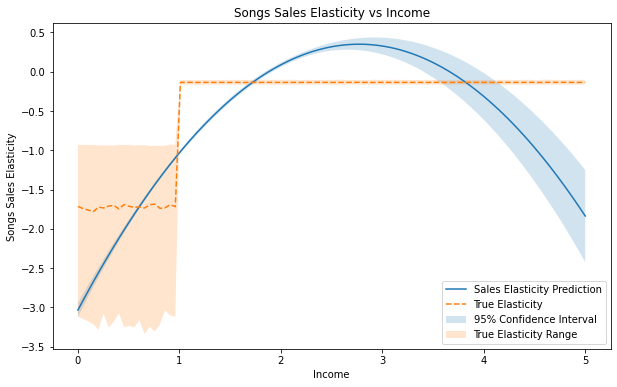

In [11]:
# Compare the estimate and the truth
plt.figure(figsize=(10, 6))
plt.plot(X_test.flatten(), te_pred, label="Sales Elasticity Prediction")
plt.plot(X_test.flatten(), truth_te_estimate, "--", label="True Elasticity")
plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0],
    te_pred_interval[1],
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.fill_between(
    X_test.flatten(),
    truth_te_lower,
    truth_te_upper,
    alpha=0.2,
    label="True Elasticity Range",
)
plt.xlabel("Income")
plt.ylabel("Songs Sales Elasticity")
plt.title("Songs Sales Elasticity vs Income")
plt.legend(loc="lower right")

上のプロットから、真の処置効果は所得の非線形関数であり、所得が1より小さい場合は弾力性が-1.75前後で、所得が1より大きい場合は小さな負の値であることがわかります。 このモデルは2次処置効果にフィットしますが、あまりフィットしていません。しかし、それでも全体的な傾向を捉えています：弾力性は負であり、人々は所得が高いほど価格の変化に敏感ではありません。



In [12]:
# Get the final coefficient and intercept summary
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
income,2.442,0.071,34.292,0.0,2.302,2.581
income^2,-0.44,0.024,-18.243,0.0,-0.488,-0.393
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-3.033,0.045,-67.933,0.0,-3.121,-2.946


`LinearDML` estimator can also return the summary of the coefficients and intercept for the final model, including point estimates, p-values and confidence intervals. From the table above, we notice that $income$ has positive effect and ${income}^2$ has negative effect, and both of them are statistically significant.

## ノンパラメトリック異質性
真の処置効果関数が非線形であることはすでにわかっているので ForestDMLCateEstimatorを使用して別のモデルを当てはめます。これは、完全に処置効果のノンパラメトリック推定を前提としています。

In [13]:
# Train EconML model
est = CausalForestDML(
    model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor()
)
est.fit(log_Y, log_T, X=X, W=W, inference="blb")
# Get treatment effect and its confidence interval
te_pred = est.effect(X_test)
te_pred_interval = est.effect_interval(X_test)

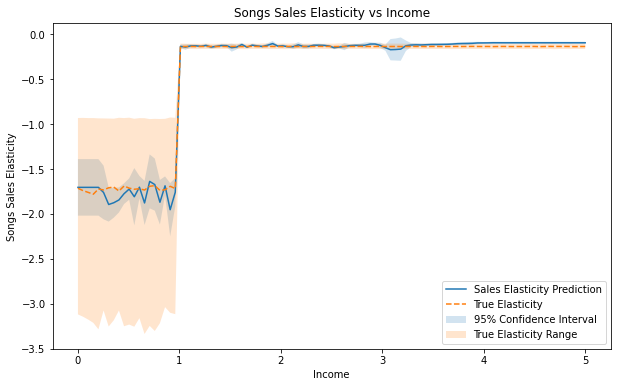

In [14]:
# Compare the estimate and the truth
plt.figure(figsize=(10, 6))
plt.plot(X_test.flatten(), te_pred, label="Sales Elasticity Prediction")
plt.plot(X_test.flatten(), truth_te_estimate, "--", label="True Elasticity")
plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0],
    te_pred_interval[1],
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.fill_between(
    X_test.flatten(),
    truth_te_lower,
    truth_te_upper,
    alpha=0.2,
    label="True Elasticity Range",
)
plt.xlabel("Income")
plt.ylabel("Songs Sales Elasticity")
plt.title("Songs Sales Elasticity vs Income")
plt.legend(loc="lower right")

We notice that this model fits much better than the `LinearDML`, the 95% confidence interval correctly covers the true treatment effect estimate and captures the variation when income is around 1. Overall, the model shows that people with low income are much more sensitive to the price changes than higher income people.

## EconMLで処置効果を理解する
EconMLには、処置効果をよりよく理解するための解釈可能なツールが含まれています。処置効果は複雑なものですが、多くの場合、提案された変更に対して肯定的に反応するユーザ、中立的に反応するユーザ、否定的に反応するユーザを区別できる単純なルールに私たちは興味があります。

EconMLの SingleTreeCateInterpreter は、EconMLの推定量のいずれかによって出力された処置効果について単一の決定木を学習することで、相互適用性を提供します。下の図では、暗赤色のユーザは割引に対して強く反応し、白色のユーザは割引に対して軽く反応していることがわかります。

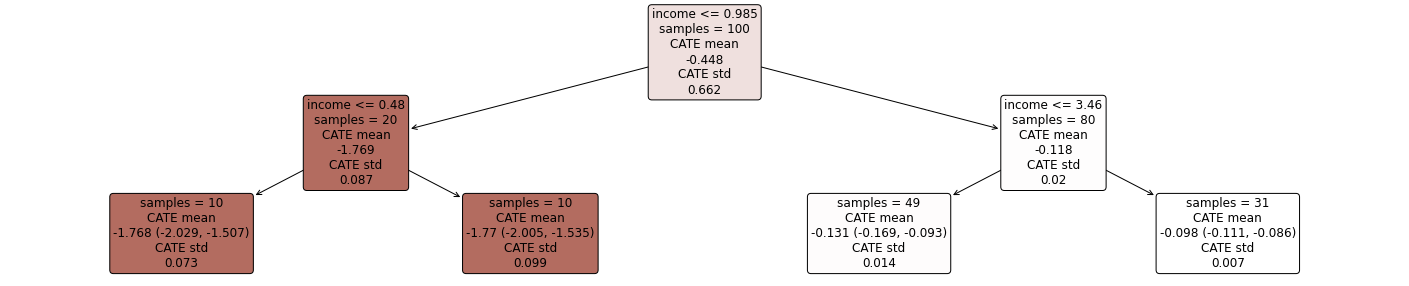

In [15]:
intrp = SingleTreeCateInterpreter(
    include_model_uncertainty=True, max_depth=2, min_samples_leaf=10
)
intrp.interpret(est, X_test)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X.columns, fontsize=12)

## EconMLで方針決定を行う
需要ではなく収益を最大化するように方針を決定したいと考えています。 このシナリオでは、


\begin{align}
Rev & = Y \cdot T \\
    & = \exp^{log(Y)} \cdot T\\
    & = \exp^{(\theta(X) \cdot log(T) + f(X,W) + \epsilon)} \cdot T \\
    & = \exp^{(f(X,W) + \epsilon)} \cdot T^{(\theta(X)+1)}
\end{align}


With the decrease of price, revenue will increase only if $\theta(X)+1<0$. Thus, we set `sample_treatment_cast=-1` here to learn **what kinds of customers we should give a small discount to maximum the revenue**.

The EconML library includes policy interpretability tools such as `SingleTreePolicyInterpreter` that take in a treatment cost and the treatment effects to learn simple rules about which customers to target profitably. In the figure below we can see the model recommends to give discount for people with income less than $0.985$ and give original price for the others.

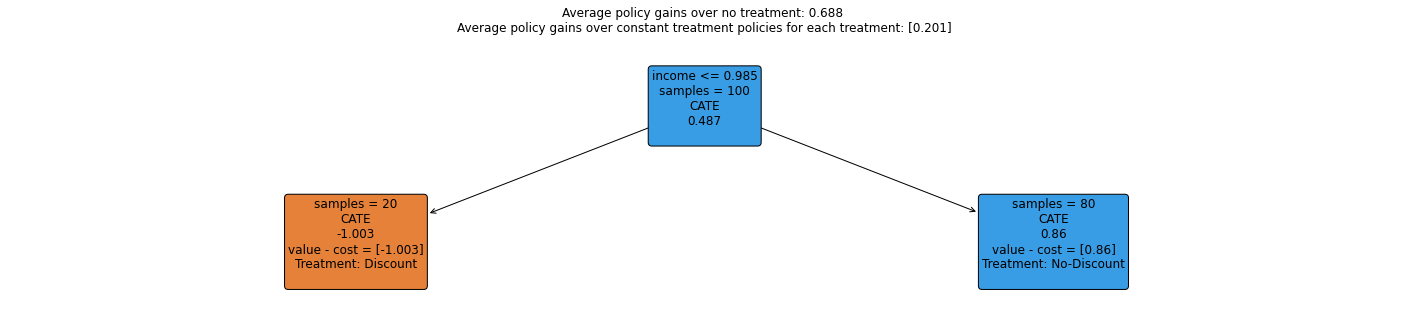

In [16]:
intrp = SingleTreePolicyInterpreter(
    risk_level=0.05, max_depth=2, min_samples_leaf=1, min_impurity_decrease=0.001
)
intrp.interpret(est, X_test, sample_treatment_costs=-1)
plt.figure(figsize=(25, 5))
intrp.plot(
    feature_names=X.columns, treatment_names=["Discount", "No-Discount"], fontsize=12
)

Now, let us compare our policy with other baseline policies! Our model says which customers to give a small discount to, and for this experiment, we will set a discount level of 10% for those users. Because the model is misspecified we would not expect good results with large discounts. Here, because we know the ground truth, we can evaluate the value of this policy.

In [17]:
# define function to compute revenue
def revenue_fn(data, discount_level1, discount_level2, baseline_T, policy):
    policy_price = baseline_T * (1 - discount_level1) * policy + baseline_T * (
        1 - discount_level2
    ) * (1 - policy)
    demand = demand_fn(data, policy_price)
    rev = demand * policy_price
    return rev

In [18]:
policy_dic = {}
# our policy above
policy = intrp.treat(X)
policy_dic["Our Policy"] = np.mean(revenue_fn(train_data, 0, 0.1, 1, policy))

## previous strategy
policy_dic["Previous Strategy"] = np.mean(train_data["price"] * train_data["demand"])

## give everyone discount
policy_dic["Give Everyone Discount"] = np.mean(
    revenue_fn(train_data, 0.1, 0, 1, np.ones(len(X)))
)

## don't give discount
policy_dic["Give No One Discount"] = np.mean(
    revenue_fn(train_data, 0, 0.1, 1, np.ones(len(X)))
)

## follow our policy, but give -10% discount for the group doesn't recommend to give discount
policy_dic["Our Policy + Give Negative Discount for No-Discount Group"] = np.mean(
    revenue_fn(train_data, -0.1, 0.1, 1, policy)
)

## give everyone -10% discount
policy_dic["Give Everyone Negative Discount"] = np.mean(
    revenue_fn(train_data, -0.1, 0, 1, np.ones(len(X)))
)

In [19]:
# get policy summary table
res = pd.DataFrame.from_dict(policy_dic, orient="index", columns=["Revenue"])
res["Rank"] = res["Revenue"].rank(ascending=False)
res

,Revenue,Rank
Our Policy,14.686241,2.0
Previous Strategy,14.349342,4.0
Give Everyone Discount,13.774469,6.0
Give No One Discount,14.294606,5.0
Our Policy + Give Negative Discount for No-Discount Group,15.564411,1.0
Give Everyone Negative Discount,14.612670,3.0


**We beat the baseline policies!** Our policy gets the highest revenue except for the one raising the price for the No-Discount group. That means our currently baseline price is low, but the way we segment the user does help increase the revenue!

## 結論

このノートブックでは、EconMLを用いることで、以下のようなことが可能であることを示しました。

- モデルの仕様が間違っていても処置効果を正しく推定する
- 結果として得られる個人レベルの処置効果を解釈する
- 以前の方針とベースラインの方針に勝る方針決定をする

To learn more about what EconML can do for you, visit our [website](https://aka.ms/econml), our [GitHub page](https://github.com/microsoft/EconML) or our [documentation](https://econml.azurewebsites.net/). 